# Predicting Location of Accidents

**Business Understanding**: If we are able to predict the location of an accident or the factors that are most associated to model, we could leverage it to anticipate where an accident would occur and when to get tow trucks or other related businesses prepared.

For this model we want to remove all variables that would give away the location such as the state, the coordinates, etc.. That would give away the location that we are trying to predict. We will include the boolean categorical variables that tell us if there was a presence of something at the accident such as Stop sign, Amenity, Yield, Crossing, etc. All the categorical variables are not missing any values so we do not need to impute the categorical variables differently than the continuous variables.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [1]:
import pandas as pd
import numpy as np
import sklearn 
import gc 
#visualization packages
import matplotlib
import matplotlib.dates as md
import matplotlib.pyplot as plt
import seaborn as sns
#modelling packages
import xgboost as xgb 
from sklearn import preprocessing 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [0]:
df = pd.read_csv('/content/drive/My Drive/df_with_feature_engineering.csv')

In [0]:
# df = df.sample(1000000)

## Classification Model
### Prepare the data

In [0]:
# remove all rows where fips is na
df2 = df.dropna(subset=['fips'])
X = df2[['Severity','Distance(mi)','Temperature(F)','Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight','Astronomical_Twilight','Hour','Duration_mins']]
y = df2['fips']
# change type from object to int
y = y.astype(int)

In [0]:
# need to label encode object type variables
cat_vars = X.select_dtypes('object').astype(str).apply(preprocessing.LabelEncoder().fit_transform)

In [0]:
# remove the object vars so we can concatenate both pieces
X2 = X.select_dtypes(exclude=['object'])

In [6]:
X = pd.concat([X2,cat_vars],axis=1)
X.head()

,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Hour,Duration_mins,Wind_Direction,Weather_Condition,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,3,0.01,36.9,NaN,91.0,29.68,10.0,NaN,0.02,False,False,False,False,False,False,False,False,False,False,False,False,False,5,314,1,52,1,1,1,1
1,2,0.01,37.9,NaN,100.0,29.65,10.0,NaN,0.00,False,False,False,False,False,False,False,False,False,False,False,False,False,6,30,1,52,1,1,1,0
2,2,0.01,36.0,33.3,100.0,29.67,10.0,3.5,NaN,False,False,False,False,False,False,False,False,False,False,False,True,False,6,30,16,75,1,1,0,0
3,3,0.01,35.1,31.0,96.0,29.64,9.0,4.6,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,7,30,16,72,1,0,0,0
4,2,0.01,36.0,33.3,89.0,29.65,6.0,3.5,NaN,False,False,False,False,False,False,False,False,False,False,False,True,False,7,30,16,72,0,0,0,0


In [7]:
X.shape

(2871275, 30)

In [0]:
# impute na by mean because all of the missing values are continuous 
X = X.fillna(X.mean())

## Modelling

In [0]:
# since we have a few million rows of data we can train a bigger proportion of it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# free some space if possible
gc.collect()

10

I chose a Random Forest classifier because it can handle the mixed types of variables. However my computer was not able to run the model so instead I used XGBoost classifier to obtain the feature importance and the XGBoost algorithm is also able to handle the mixed types of variables.

In [0]:
# Consumes a lot of RAM - compute this if your computer can handle it
# # Create a Classifier
# clf=RandomForestClassifier()

# # Train the model using the training sets y_pred=clf.predict(X_test)
# clf.fit(X_train,y_train)

# y_pred=clf.predict(X_test)

In [0]:
# Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [0]:
xg_clf = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)


In [0]:
xg_clf.fit(X_train,y_train)

In [0]:
preds = xg_clf.predict(X_test)

## Results

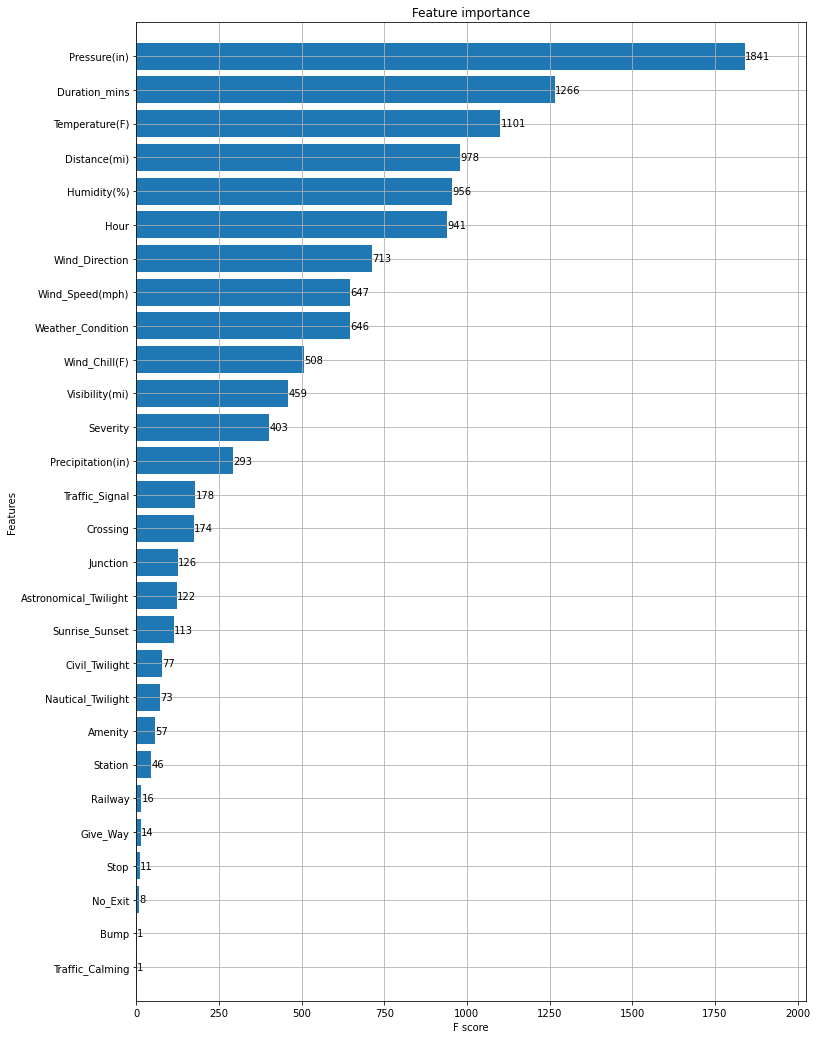

In [13]:
xgb_prames = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'silent': 1,
    'seed' : 0
}

dtrain = xgb.DMatrix(X_train,y_train,feature_names=X_train.columns.values)

model = xgb.train(dict(xgb_prames, silent=0), dtrain, num_boost_round=50)


fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Conclusion

From this plot above we can see the variables most associated with the location of an accident. Air Pressure in inches is the leading factor. This means there is a relationship between accidents and air pressure, perhaps accidents occur more in places with higher air pressure. Other factors include Humidity, Temperature, Distance (the length of the road affected by the accident), Hour of the day, etc.. Using these factors, tow truck companies or related businesses can anticipate an accident and be prepared for it.